# Markov Chain Monte Carlo 

We want to estimate the posterior distribution, but this is often intractable.

Markov Chain Monte Carlo  (MCMC) is a computational technique used to approximate complex probability distributions by generating a <font color='orange'>sequence of (correlated) samples</font>, where each sample is obtained by iteratively transitioning through a Markov chain with carefully designed transition probabilities.

The MCMC simulation method is the modern way of approximating complex posterior distributions. The idea is analogous to treating the posterior distribution as the population, and then repeatedly draw samples from it. When we draw a large enough sample (say 1,000), the sample distribution should be very close to the population distribution.

One tweak of MCMC from the above analogy is that the samples drawn are <font color='orange'>correlated</font>, so that if the first sample is high, the next one is more likely to be high too. This is needed because we don’t have a direct way to draw samples from the posterior distribution, which usually has a very complex form; instead we have some algorithms that can indirectly get us to the posterior. The correlation among samples usually is not a big problem, except that we need to draw more samples to compensate for it. 

Aa overview of how an MCMC works is as follows:

- Draw samples from a (simple) proposal distribution so that each draw depends only on the state of the previous draw (i.e. the samples form a <font color='orange'>Markov chain</font>).
- Under certain conditions, the Markov chain will have a unique stationary distribution.

- We set up an acceptance criteria for each draw based on comparing successive states with respect to a target distribution that enusre that the stationary distribution is the posterior distribution we are searching for.

- There is no need to evaluate the potentially intractable marginal likelihood.

- After sufficient number of iterations, the Markov chain of accepted draws will converge to the staionary distribution, and we can use those samples as (correlated) draws from the posterior distribution, and find functions of the posterior distribution.

Some examples of MCMC algorithms are

1. The Metropolis algorithm,
3. The Metropolis-Hastings algorithm,
4. The Gibbs sampler,
5. Hamiltonian Monte Carlo,
6. No U-turn sampler (and several variants).

Let us take a close look at some of these algorithms.

## Metropolis-Hastings algorithm

The Metropolis-Hastings algorithm is an MCMC technique used for generating samples from a probability distribution. It's particularly useful when direct sampling from the distribution is difficult or impossible, but evaluating the probability density function (PDF) up to a constant of proportionality is feasible. It's particularly useful for sampling from <font color='orange'>high-dimensional</font>, complex distributions. The algorithm iteratively generates samples from a target distribution by constructing a Markov chain.

Let $\pi(x)$ be the target probability density function (pdf) from which we want to sample. The steps of the Metropolis-Hastings algorithm are as follows:

1. **Initialization**: Start with an initial state $x_0$ from the sample space.

2. **Proposal Generation**: At each iteration $t$, propose a new state $x'$ based on some proposal distribution $q(x' | x_t)$, which defines the probability of transitioning from state $x_t$ to $x'$.

3. **Acceptance Probability**: Calculate the acceptance probability $\alpha$ as follows:

$$
\alpha = \min \left(1, \frac{\pi(x')}{\pi(x_t)} \times \frac{q(x_t | x')}{q(x' | x_t)} \right)
$$

where $\pi(x)$ is the target probability density function and $q(x' | x_t)$ is the proposal distribution.

4. **Acceptance or Rejection**: Generate a uniform random number $u$ from the interval [0, 1]. If $u < \alpha$, accept the proposed state $x'$ as the next state: $x_{t+1} = x'$; otherwise, stay at the current state: $x_{t+1} = x_t$.

5. **Iteration**: Repeat steps 2-4 for a sufficient number of iterations.

The resulting sequence of samples $x_1, x_2, ..., x_n$ forms a Markov chain that converges to the target distribution $\pi(x)$ as $n$ approaches infinity. Proper choice of the proposal distribution is crucial for efficient sampling, and tuning its parameters can significantly impact the algorithm's performance.

The <font color='teal'>Metropolis</font> algorithm is a special case of the Metropolis-Hastings algorithm where the proposal distribution is symmetric, meaning $q(x' | x_t) = q(x_t | x')$, leading to simplifications in the acceptance probability calculation.


## Metropolis-Hastings by hand

Let's implement the Metropolis-Hastings algorithm for sampling from the normal distribution $\mathcal{N}(5,1)$. As the proposal distribution we will use $\mathcal{N}(0,1)$, making the proposal a random walk process. Note that this proposal is symmetric, hence, we don't need to account for it in the acceptance ratio.
```{margin}
We have already seen how to use Numpyro to obtain samples from this distribution. Here we use it rather for the purpose of demonstration, and not because we don't have other means of sampling.
```

In [39]:
import numpy as np
import jax.numpy as jnp

import scipy.stats as stats

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [40]:
# Target distribution: Univariate normal distribution with mean = 5, variance = 1
def target_distribution(x):
    return np.exp(-(x - 5)**2 / 2) / np.sqrt(2 * np.pi)

# Proposal distribution: Normal distribution with mean = 0 and variance = 1
def proposal_distribution(x, sigma=1):
    return np.random.normal(x, sigma)

# Metropolis-Hastings algorithm
def metropolis_hastings(num_samples, initial_state, proposal_sigma):
    samples = [initial_state]
    current_state = initial_state

    for _ in range(num_samples):
        # Propose a new state
        proposed_state = proposal_distribution(current_state, proposal_sigma)
        
        # Calculate acceptance ratio
        acceptance_ratio = min(1, target_distribution(proposed_state) / target_distribution(current_state))
        
        # Accept or reject the proposed state
        if np.random.uniform(0, 1) < acceptance_ratio:
            current_state = proposed_state
        samples.append(current_state)

    return samples

In [41]:
# Parameters
num_samples = 1000
initial_state = -3     # Initial state
proposal_sigma = 0.2   # Standard deviation for the proposal distribution

# Generate samples using Metropolis-Hastings algorithm
samples = metropolis_hastings(num_samples, initial_state, proposal_sigma)


Now when we have collected samples, we can plot them to make a <font color='orange'>traceplot</font>, and we can also plot the sampling distribution we obtained:

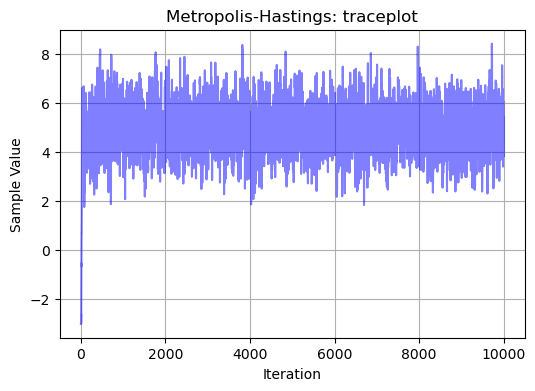

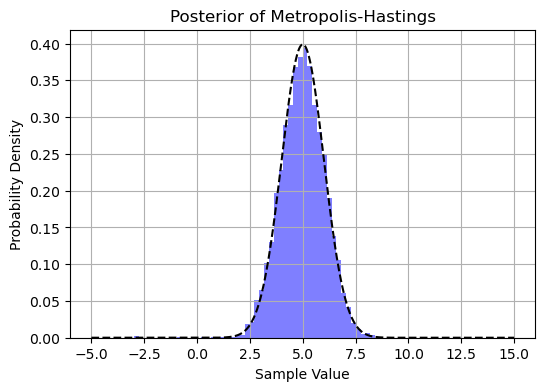

In [48]:
# Traceplot
plt.figure(figsize=(6, 4))
plt.plot(samples, color='blue', alpha=0.5)
plt.xlabel('Iteration')
plt.ylabel('Sample Value')
plt.title('Metropolis-Hastings: traceplot')
plt.grid(True)
plt.show()

# Plot posterior
plt.figure(figsize=(6, 4))
plt.hist(samples, bins=50, color='blue', alpha=0.5, density=True)

x = np.linspace(-5, 15, 1000)
plt.plot(x, target_distribution(x), color='black', linestyle='--', label='True Distribution')
plt.xlabel('Sample Value')
plt.ylabel('Probability Density')
plt.title('Posterior of Metropolis-Hastings')
plt.grid(True)
plt.show()


## Warm-up

We can notice on the traceplot, that the initial value we started with wasn't great. For this reason, it is common to use a <font color='orange'>warm-up</font> period. 

A warm-up, also known as a <font color='orange'>burn-in</font> period, refers to an initial phase where the algorithm runs to reach a state of convergence or equilibrium. During this phase, the algorithm explores the parameter space and adjusts its state transition probabilities, aiming to approach the target distribution.

The initial part of the chain may have not reached convergence yet. Furthermore, it may also include phase for adapting algorithm parameters. So the initial part of the chain may be non-representative. This initial burn-in part must be thrown away.


The samples generated during the warm-up period are typically discarded as they may not accurately represent the target distribution. Once the warm-up phase is complete, the samples generated by the MCMC algorithm are considered to be from the stationary distribution and are used for inference or analysis.

The length of the warm-up period can vary depending on factors such as the complexity of the target distribution and the effectiveness of the MCMC algorithm in exploring the parameter space. A longer warm-up period may be required for more complex distributions or when starting from a distant initial state.

## Chains

We have ran the simluation forward once. In fact, we could run several simulation fowards in parallel, each with its own initial values, to see whether they converge to the same distribution.

<font color='orange'>Chains</font> refer to the sequences of samples generated by the algorithm as it iterates through the parameter space. Each chain represents a trajectory of parameter values explored by the algorithm over multiple iterations. Multiple chains can be run simultaneously, each starting from different initial parameter values, to improve convergence diagnostics and assess the mixing properties of the algorithm. 

Running several chains from different initial values can help convergence diagnostics, for example, because visual inspection of the chains is straightforward.

Let us rerun the same experiment as above, but now by using three chains.

In [1]:
# Parameters
num_samples = 1000
initial_states = [-12, 5, 10]  # Initial states for each chain
proposal_sigma = 0.2         # Standard deviation for the proposal distribution

# Generate samples using Metropolis-Hastings algorithm for each chain
chains_samples = []

for initial_state in initial_states:
    samples = metropolis_hastings(num_samples, initial_state, proposal_sigma)
    chains_samples.append(samples)

# Plot all chains on one plot
plt.figure(figsize=(6, 4))
colors = ['blue', 'green', 'red']  # Define colors for each chain
for idx, samples in enumerate(chains_samples):
    plt.plot(samples, color=colors[idx], alpha=0.5, label=f'Chain {idx+1}')

plt.xlabel('Iteration')
plt.ylabel('Sample Value')
plt.title('Traceplot of Metropolis-Hastings Chains')
plt.legend()
plt.grid(True)
plt.show()

# Plot posteriors for each chain
plt.figure(figsize=(6, 4))
for idx, samples in enumerate(chains_samples):
    plt.hist(samples, bins=50, color=colors[idx], alpha=0.5, density=True, label=f'Chain {idx+1}')

x = np.linspace(-5, 15, 1000)
plt.plot(x, target_distribution(x), color='black', linestyle='--', label='True Distribution')
plt.xlabel('Sample Value')
plt.ylabel('Probability Density')
plt.title('Posteriors of Metropolis-Hastings Chains')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'metropolis_hastings' is not defined

## Convergence diagnostics

Assessing MCMC convergence involves evaluating whether the chains generated by the algorithm have reached a stationary distribution and are sampling effectively from the target distribution. 

Reaching convergence on the sample is essential, otherwise, the samples do not come from the posterior distribution and subsequent analysis are meaningless.




A few common methods for assessing MCMC convergence are:

- **Visual Inspection: traceplots**: Plotting traceplots of the chains can provide visual cues about convergence. Traceplots show the parameter values sampled at each iteration for each chain. Flat, stable traces suggest convergence, while erratic or trending traces indicate potential issues.

- **Visual Inspection: density plots**: Density Plots: Density plots of samples from different chains overlaid with the target distribution can visually assess convergence. As chains converge, their density plots should match the target distribution.

- **Auto-correlation Plots**: Auto-correlation plots show how each sample in the chain is correlated with previous samples. Rapid decay in auto-correlation suggests convergence, while slow decay may indicate lack of convergence.


- **Effective Sample Size (ESS)**: ESS estimates the number of *independent* samples obtained from the MCMC chains. It quantifies the amount of information each chain provides about the target distribution. Higher ESS values indicate more reliable estimates.

- **Gelman-Rubin Diagnostic (R-hat)**: This diagnostic compares the variance between chains to the variance within chains. An R-hat value close to 1 indicates convergence. Values significantly greater than 1 suggest that more iterations are needed.

We have already performed visual diagnostics. Let's use the more quantitative measures to assess convergence.


### Autocorrelation plots

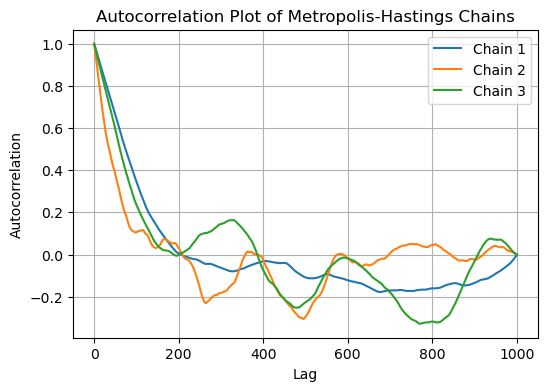

In [57]:
# Compute autocorrelation function (ACF) for a given chain
def autocorr(chain):
    n = len(chain)
    mean = np.mean(chain)
    c0 = np.sum((chain - mean) ** 2) / n
    autocorr = np.correlate(chain - mean, chain - mean, mode='full') / (n * c0)
    return autocorr[len(autocorr)//2:]

# Compute autocorrelation for each chain
autocorr_values = []
for chain in chains_samples:
    autocorr_values.append(autocorr(chain))

# Plot autocorrelation for each chain
plt.figure(figsize=(6, 4))
for idx, acf in enumerate(autocorr_values):
    plt.plot(acf, label=f'Chain {idx + 1}')

plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Plot of Metropolis-Hastings Chains')
plt.legend()
plt.grid(True)
plt.show()

Since neigbouring samples will contain similar information adn are auto-correlated, one can decide to save only every second, or fifth, or tenth sample. This is called <font color='orange'>thinning</font>.

*Excercise*: 

- Increase the number of iterations in the algorithm above and create an ACF plot. What do you conclude?
- Experiemnt with the values of parameter `proposal_sigma`. What do you observe?

## Computing effective sample size (ESS)

The effective sample size describes the efficiency of dependent sample in terms of independent draws from the same distribution, is descriptive of the effectiveness of the sampling and of the autocorrelation of the chain.

The formula for estimating the Effective Sample Size (ESS) of a Markov chain is:

$$\text{ESS} = \frac{N}{1 + 2 \sum_{t=1}^{T} \rho_t}$$

Where:

- $N$ is the total number of samples in the chain,

- $T$ is the lag, which represents the maximum number of auto-correlation terms considered, 

- $\rho_t$ s the auto-correlation at lag $t$, i.e., the correlation between two consecutive samples separated by $t$ iterations.

In practice, $T$ is often chosen such that $\rho_T$ is small, indicating that the auto-correlation has decayed sufficiently. The sum $\sum_{t=1}^T \rho_t$ is then approximately truncating at $T$. 



In [55]:
# Compute auto-correlation function (ACF) for each chain
def autocorr(x, t=1):
    return np.corrcoef(np.array([x[:-t], x[t:]]))

acf_values = []
for chain in chains_samples:
    acf_values.append([autocorr(chain, t)[0, 1] for t in range(1, len(chain)//5)])

# Estimate Effective Sample Size (ESS) for each chain
ess_values = []
for acf in acf_values:
    T = 100  # Truncate at lag T
    ess_values.append(num_samples / (1 + 2 * sum(acf[:T])))

# Print ESS values for each chain
for idx, ess in enumerate(ess_values):
    print(f'Chain {idx + 1} - ESS: {ess}')

Chain 1 - ESS: 5.318994932301834
Chain 2 - ESS: 11.468669990620734
Chain 3 - ESS: 6.9135364611182855


## Computing the Gelman-Rubin Statistic ($\hat{R}$)

To compute the Gelman-Rubin statistic (often denoted as $\hat{R}$), we need to run multiple chains and compare their variability within each chain to their variability between chains. Here's the algorithm to compute $\hat{R}$:


1. Run $m$ Markov chains of length $n$, where $m$ is typically greater than 1.
2. For each scalar parameter $\theta$, compute the within-chain variance $W$ and the between-chain variance $B$.
3. Calculate the pooled within-chain variance $\hat{V}$ as the weighted average of the within-chain variances.
4. Calculate the potential scale reduction factor $\hat{R}$ as the square root of the ratio of the pooled within-chain variance to the within-chain variance:
    $$\hat{R} = \sqrt{\frac{\hat{V}}{W}}$$
5. If $\hat{R}$ is close to 1, it indicates convergence of the chains.

The Gelman-Rubin statistic $\hat{R}$ is a measure of convergence for the Markov chains. It quantifies the degree to which multiple chains agree with each other, providing a diagnostic tool for assessing convergence in Markov Chain Monte Carlo (MCMC) simulations.


In [56]:
import numpy as np

# Function to compute Gelman-Rubin statistic (R-hat)
def gelman_rubin(chains):
    num_chains = len(chains)
    num_samples = len(chains[0])
    num_parameters = len(chains[0][0])

    # Calculate means and variances for each chain and parameter
    chain_means = np.mean(chains, axis=1)
    chain_vars = np.var(chains, axis=1, ddof=1)

    # Calculate within-chain variance (W) and between-chain variance (B)
    W = np.mean(chain_vars, axis=0)
    B = num_samples / (num_chains - 1) * np.sum((chain_means - np.mean(chain_means, axis=0))**2, axis=0)

    # Calculate pooled within-chain variance
    V_hat = (num_samples - 1) / num_samples * W + 1 / num_samples * B

    # Calculate potential scale reduction factor (R-hat)
    R_hat = np.sqrt(V_hat / W)
    return R_hat

# Example usage
chains = np.random.normal(loc=0, scale=1, size=(3, 1000, 1))  # Three chains with 1000 samples each
R_hat = gelman_rubin(chains)
print("R-hat for each parameter:", R_hat)


R-hat for each parameter: [0.99951325]


## Gibbs sampling

Another simple example of MCMC is the Gibbs sampling algorithm.

In Gibbs sampling, you iteratively sample from the conditional distributions of each variable given the current values of all other variables. This is particularly useful in situations where you have a joint distribution of multiple variables and want to sample from the posterior distribution of one variable while keeping the others fixed.

Here's a simplified outline of the Gibbs sampling algorithm:

1. Start with initial values for all variables.
2. Choose one variable to update.
3. Sample a new value for the chosen variable from its conditional distribution given the current values of all other variables.
4. Repeat steps 2-3 for each variable in the model.
5. Repeat the process for a sufficient number of iterations.

Each iteration of Gibbs sampling updates one variable at a time, conditional on the current values of the other variables. Over iterations, the samples generated by Gibbs sampling converge to samples from the joint posterior distribution of all variables.

Gibbs sampling is used where it's difficult or computationally expensive to sample directly from the joint posterior distribution. It's relatively simple to implement.

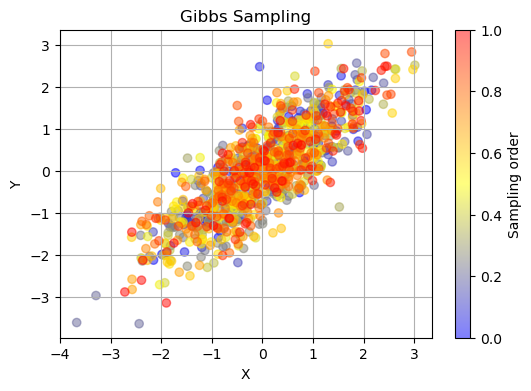

In [58]:
# Define the mean and covariance matrix of the bivariate normal distribution
mu = np.array([0, 0])
covariance = np.array([[1, 0.8], [0.8, 1]])

# Function to sample from the conditional distribution of x given y
def sample_x_given_y(y, mu, covariance):
    mu_x_given_y = mu[0] + covariance[0, 1] / covariance[1, 1] * (y - mu[1])
    sigma_x_given_y = np.sqrt(1 - covariance[0, 1]**2 / covariance[1, 1]**2)
    return np.random.normal(mu_x_given_y, sigma_x_given_y)

# Function to sample from the conditional distribution of y given x
def sample_y_given_x(x, mu, covariance):
    mu_y_given_x = mu[1] + covariance[0, 1] / covariance[0, 0] * (x - mu[0])
    sigma_y_given_x = np.sqrt(1 - covariance[0, 1]**2 / covariance[0, 0]**2)
    return np.random.normal(mu_y_given_x, sigma_y_given_x)

# Initialize variables
num_samples = 1000
x_samples = np.zeros(num_samples)
y_samples = np.zeros(num_samples)

# Initial guess
x_samples[0] = np.random.normal(0, 1)
y_samples[0] = np.random.normal(0, 1)

# Run Gibbs sampling
for i in range(1, num_samples):
    x_samples[i] = sample_x_given_y(y_samples[i-1], mu, covariance)
    y_samples[i] = sample_y_given_x(x_samples[i], mu, covariance)

# Create a color gradient for the samples
colors = np.linspace(0, 1, num_samples)
cmap = LinearSegmentedColormap.from_list("my_cmap", [(0, 'blue'), (0.5, 'yellow'), (1, 'red')])

# Plot the samples
plt.figure(figsize=(6, 4))
sc = plt.scatter(x_samples, y_samples, c=colors, cmap=cmap, alpha=0.5)
plt.colorbar(sc, label='Sampling order')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Gibbs Sampling')
plt.grid(True)
plt.show()


## Hamiltonian Monte Carlo

Hamiltonian Monte Carlo algorithm introduces gradient information in improving efficiency on the proposals and reduce random walk behavior of the sampling. The gradients help the algorithm to find high probability states. HMC can potentially improve sampling efficiently, but the gradients of the distribution need to be tractable. Additional parameters need to be tuned, which makes its implementation more difficult than other MC methods such as Gibbs or Metropolis-Hasting sampling. However, methods have been developed for automatic adaptation of the parameters, such as no-U-turn sampler (NUTS).

## More MCMC algorithms

To watch some MCMC algorithms in action, check out [this](https://chi-feng.github.io/mcmc-demo/app.html?algorithm=RandomWalkMH&target=banana) online resourse.

**Question**: which algorithm, in your opinion, is the most efficient?

## Enough of hand-crafted MCMCs!

Was it very painful to write a sampler by hand?

If not, bare in mind that we only wrote the simplest one possible! Sampling algorithms can get very complicated. 🧠